# How does volatility impact returns

I was talking with a friend yesterday who told me that, given 2 mutual funds with equal average return rates, the one that has less volatility gets you more money in the long run. This is a test of that statement using Monte Carlo simulations.

Another way he put this was if there were 2 mutual funds with equal average returns, but one had a better ratio of positive_returns:negative_returns, the one with this ratio higher would get you more money in the long run.

So we're going to these scenarios...

Constants between scenarios:
* 30 years
* Adding \$5,500 per year to fund
* Starting with \$0 in the beginning

First, we'll these test 2 mutual funds:
* mean of 8% return per year, and standard deviation of 2%
* mean of 8% return per year, and standard deviation of 10%

Then, we'll test these 2 mutual funds:
* mean of 8% return per year, 20 years of positive gains, 10 years of negative returns
* mean of 8% return per year, 10 years of negative returns, and 20 years of positive gains

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Graphing helper function
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

## Return rates

First, we need a way to generate the return rates for each mutual fund. We'll do this by sampling a normal distribution with these properties:

* mean = average return of mutual fund
* standard deviation = standard deviation of mutual fund

In [4]:
def generate_return_rates(return_mean, return_std, years):
    return return_mean + return_std * np.random.randn(years)

### Example of what rate of returns looks like

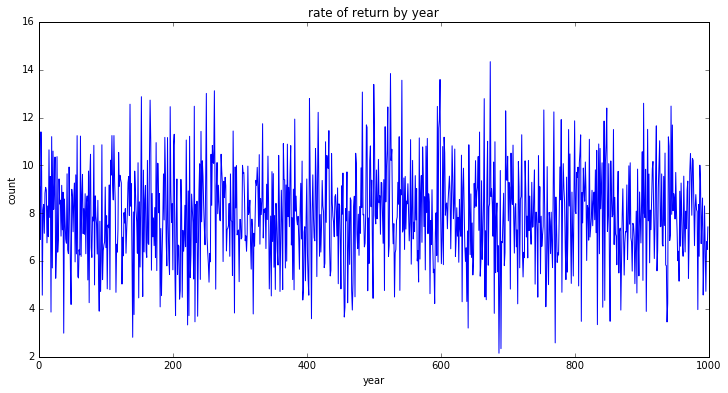

In [5]:
return_rates = generate_return_rates(8, 2, 1000)
year_range = range(1000)
setup_graph(title='rate of return by year', x_label='year', y_label='count', fig_size=(12,6))
plt.plot(year_range, return_rates)

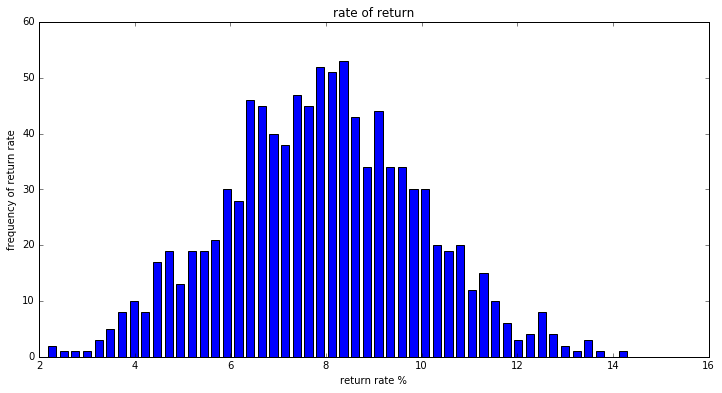

In [6]:
hist, bins = np.histogram(return_rates, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
setup_graph(title='rate of return', x_label='return rate %', y_label='frequency of return rate', fig_size=(12,6))
plt.bar(center, hist, align='center', width=width)
plt.show()

## Investment returns

Now we need a way to calculate fund returns given the sequence of return rates and the sequence of how much is contributed per year.

We'll make the following assumptions to simplify:

* Compound interest just once per year
* Contribute the same amount each year, just one time per year
* Ignore inflation

In [7]:
def calculate_fund_returns(contribution_per_year, returns_by_year, starting_principal=0):
    """ Calculate the fund returns for the sequence of years given.
    
    Parameters:
        * contributsions_per_year - float representing dollars contributed per year
        * returns_by_year - list of percent returns per year like [.1, -.05, ...].
    Returns the fund value by year - a list like this:
        [1000, 1026.25, 1223.75, 1100.75, ...]
    """
    principal = starting_principal
    value_by_year = []
    for return_rate in returns_by_year:
        # Add the contribution first thing each year
        principal = principal + contribution_per_year
        
        # Calculate growth/loss
        principal = principal * (1 + return_rate)
        
        value_by_year.append(principal)

    return value_by_year

##### Let's test to make sure this function seems to work

7/10 rule - we should double our money at 7% interest in 10 years

In [8]:
calculate_fund_returns(0, [0.07]*10, 1000)

[1070.0,
 1144.9,
 1225.0430000000001,
 1310.7960100000003,
 1402.5517307000005,
 1500.7303518490005,
 1605.7814764784307,
 1718.186179831921,
 1838.4592124201556,
 1967.1513572895667]

In [9]:
1000 * 1.07

1070.0

In [10]:
1070 * 1.07

1144.9

Our function looks good.

So now, let's look at our first 2 scenarios...

## Mutual Fund 1 - 8% return, 2% std deviation

In [11]:
years = range(30)
m1_return_rates = [percent / 100 for percent in generate_return_rates(8, 2, 30)]
m1_value_by_year = calculate_fund_returns(5500, m1_return_rates)

In [12]:
m1_value_by_year

[5851.6478227828902,
 12034.004820912702,
 18778.589776666733,
 27014.965000629465,
 36024.493053103281,
 45614.94696865986,
 54311.226670698976,
 65697.230944619587,
 77377.703900915978,
 90425.211896820256,
 101623.47657687055,
 116963.42092841654,
 130312.8987055972,
 146985.62771523703,
 164975.58578219361,
 185966.1024069376,
 205301.64461557072,
 224758.27812478022,
 243118.69816500632,
 259088.5789695094,
 286923.88816408248,
 315150.87614142353,
 354851.76916498516,
 384256.4606210952,
 434542.82415444386,
 469264.12806478073,
 503250.56203414471,
 548351.11589283706,
 578206.3498281932,
 640494.5542455042]

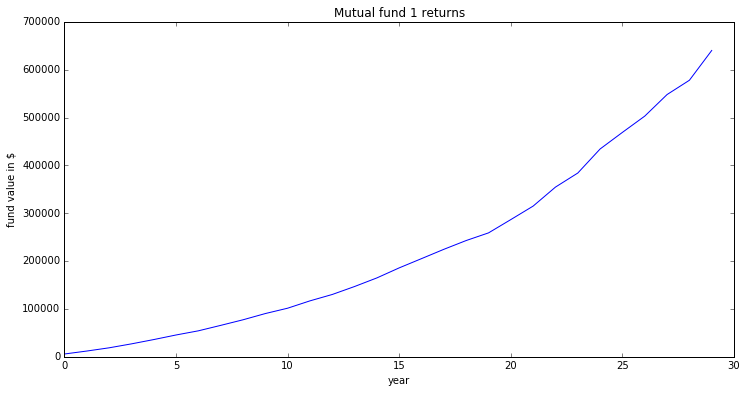

In [13]:
setup_graph(title='Mutual fund 1 returns', x_label='year', y_label='fund value in $', fig_size=(12,6))
plt.plot(years, m1_value_by_year)

So this is what fund 1 looks like. But we want to do more than 1 simulation. Let's do 100,000 simulations and find what the average ending value is.

In [14]:
def find_average_fund_return(return_mean, return_std, years, addition_per_year, num_trials):
    return_total = 0
    for i in range(num_trials):
        m1_return_rates = [percent / 100 for percent in generate_return_rates(return_mean, return_std, years)]
        m1_value_by_year = calculate_fund_returns(addition_per_year, m1_return_rates)
        final_return = m1_value_by_year[-1]  # [-1] gets the last element in the list
        return_total += final_return
    return return_total / num_trials

In [15]:
find_average_fund_return(8, 2, 30, 5500, 100000)

672992.77160434192

## Mutual Fund 2 - 8% return, 10% std deviation

In [16]:
find_average_fund_return(8, 10, 30, 5500, 100000)

673008.8774459199

This looks almost exactly the same as Mutual Fund 1. Let's try more extreme standard deviations.

In [17]:
find_average_fund_return(8, 30, 30, 5500, 100000)

672000.00711093994

30% is pretty volatile, and yet, it's still very close to the returns on the less volatile funds. So this demonstrates that lower volatility does not necessarily get better returns.